In [39]:
#| label: fig-polar
#| fig-cap: "A line plot on a polar axis"
#| echo: false

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn import metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import plotly.express as px
import ipywidgets as widgets
from ipywidgets import interactive

## Preprocessing data

In [10]:
def preprocess_data(df:pd.DataFrame)->pd.DataFrame:
    """ Function, for preprocessing data
    """
    qual_category = pd.api.types.CategoricalDtype(categories=['Hazardous', 'Poor', 'Moderate', 'Good'], ordered=True)
    df['Air Quality'] = df['Air Quality'].astype(qual_category)
    return df
    

In [15]:
def read_data(path:str='data/d.csv', y:str='Air Quality',**kwargs)->tuple:
    """ Function that read data, and split them into Train, Validation and Test datasets
    also separates, target value from others values.
    ---
    Attributes:
    path: [str], path to csv data file
    y: [str], name of Target value
    kwargs: options, use seed for random_seed
    ---
    Returns:
    tuple with Train,Validation,Test parametrs set, Target values: Train, Test, Validation
    """
    df = pd.read_csv(path)
    df = preprocess_data(df)
    # Split the training dataset into train and rest (default 60% : 40%)
    Xtrain, Xrest, ytrain, yrest = train_test_split(
        df.drop(columns=[y]), df[y], test_size=0.4, random_state=kwargs.get('seed',42))
    # Split the rest of the data into validation dataset and test dataset (default: 24% : 16%)
    Xtest, Xval, ytest, yval = train_test_split(
        Xrest, yrest, test_size=0.6, random_state=kwargs.get('seed',42))
    print(f'Dataset: {path} | Target value: {y} | Seed: {kwargs.get('seed',42)}')
    return Xtrain, Xtest, Xval, ytrain, ytest, yval

In [16]:
Xtrain, Xtest, Xval, ytrain, ytest, yval = read_data(seed=42)

Dataset: data/d.csv | Target value: Air Quality | Seed: 42


In [18]:
def train_model(*args,**kwargs):
    """Function, that trains model with specific paraketrs, defined in kwargs.
    ---
    Attributes:
    *args: Xtrain,Ytrain
    **kwargs: options for training model
    ---
    Return: trained model
    """
    X = args[0]
    y = args[1]
    return KNeighborsClassifier(**kwargs).fit(X,y)

#### Example

In [24]:
clf = train_model(Xtrain,ytrain,n_neighbors=5, metric = "minkowski", p = 1)
metrics.accuracy_score(clf.predict(Xval),yval)

0.8308333333333333

In [36]:
color_map = {
    'Good': 'green',
    'Moderate': 'yellow',
    'Poor': 'orange',
    'Hazardous': 'red'
}
category_order = ["Good", "Moderate", "Poor", "Hazardous"]

In [37]:
def show_graph(X, y_pred, x_ax='Temperature', y_ax='Humidity'):
    df_viz = X.copy()
    df_viz['Air Quality'] = y_pred
    fig = px.scatter(df_viz, x=x_ax, y=y_ax, color='Air Quality', color_discrete_map=color_map,
                     hover_data=df_viz, title='KNN Visualization',category_orders={'Air Quality':category_order})

    fig["layout"].pop("updatemenus") # optional, drop animation buttons
    fig.show()

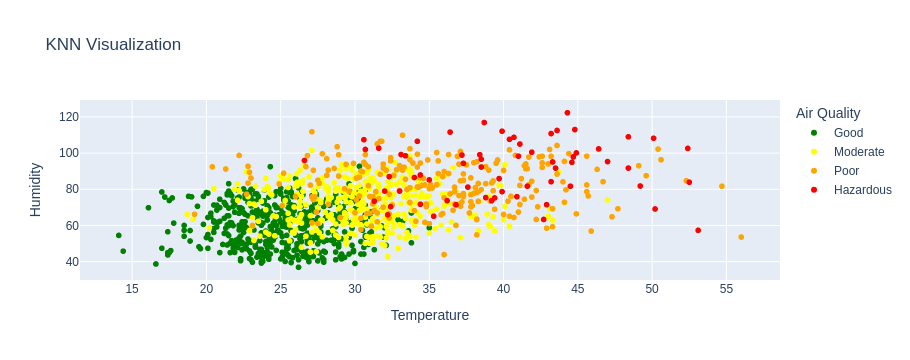

In [40]:
show_graph(Xval,clf.predict(Xval))

In [45]:
n_neighbors_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description="n_neighbors")
p_slider = widgets.IntSlider(value=5, min=1, max=20, step=1, description="p_metric")
scale = widgets.RadioButtons(
    options=['None', 'Standard', 'MinMax'],
    description='Choose normalization:',
    disabled=False
)

In [51]:
def dynamic_graph(**kwargs):
    scale = kwargs.pop('scaler')
    if scale:
        # add scale
        pass
    clf = train_model(Xtrain,ytrain,**kwargs)
    show_graph(Xval,clf.predict(Xval))


interactive_plot = interactive(dynamic_graph, n_neighbors=n_neighbors_slider, p=p_slider,scaler=scale)
interactive_plot

interactive(children=(IntSlider(value=1, description='n_neighbors', max=20, min=1), IntSlider(value=1, descrip…